In [2]:
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [248]:
CONFIRMED_CASES=pd.read_csv("confirmed_cases_JH.csv",index_col=0)
DEATHS=pd.read_csv("deaths_JH.csv",index_col=0)
codes_iso=pd.read_csv("ISO3_COUNTRYREG.csv",index_col=0)
DF_TEST=pd.read_csv("full-list-total-tests-for-covid-19.csv")

In [249]:
def reshape_data(dataset,var_name):
    ## reshape of the JH dataset
    CC=dataset
    var_calendario=CC.columns[4:]
    var_ids=CC.columns[0:4]
    CC=pd.melt(CC,var_ids,var_calendario,var_name='time',value_name=var_name)
    CC=CC.groupby(['Country/Region','time'],as_index=False)[var_name].sum()
    return CC


list_dataset=[CONFIRMED_CASES,DEATHS]
list_var_name=['confirmed_cases','deaths_cases']
DF=pd.DataFrame()

i=0
for dt,vn in zip(list_dataset,list_var_name):
    if i==0:
        DF=DF.append(reshape_data(dataset=dt,var_name=vn))
    else:
        DF=pd.merge(DF,reshape_data(dataset=dt,var_name=vn),on=['time','Country/Region'],how='left')
    i+=1


In [250]:
DF=pd.merge(DF,codes_iso[['ISO3',"Country/Region"]].drop_duplicates(),on='Country/Region',how='left')

In [251]:
## format time variable

DF_TEST['time']=pd.to_datetime(DF_TEST['Date'])
DF['time']=pd.to_datetime(DF['time'])

## change names
DF_TEST.rename({'Code':'ISO3'},inplace=True,axis=1)
DF_TEST.rename({'Total tests':'tests'},inplace=True,axis=1)

## merge
DF_ANALYSIS=pd.merge(DF,DF_TEST,on=['time','ISO3'],how='left')

## ratio variables
DF_ANALYSIS['death_rate']=DF_ANALYSIS['deaths_cases']/DF_ANALYSIS['confirmed_cases']
DF_ANALYSIS['positivity_rate']=DF_ANALYSIS['confirmed_cases']/DF_ANALYSIS['tests']

### drop null values and countries with less than 100 deaths
DF_PLT=DF_ANALYSIS.loc[DF_ANALYSIS['deaths_cases']>=100,:]
DF_PLOT=DF_PLT.dropna().copy()

## take last observation in time order
DFZ=DF_PLOT.sort_values('time',ascending=False).groupby(['ISO3'],as_index=False)['death_rate','positivity_rate','time','confirmed_cases','tests'].first()

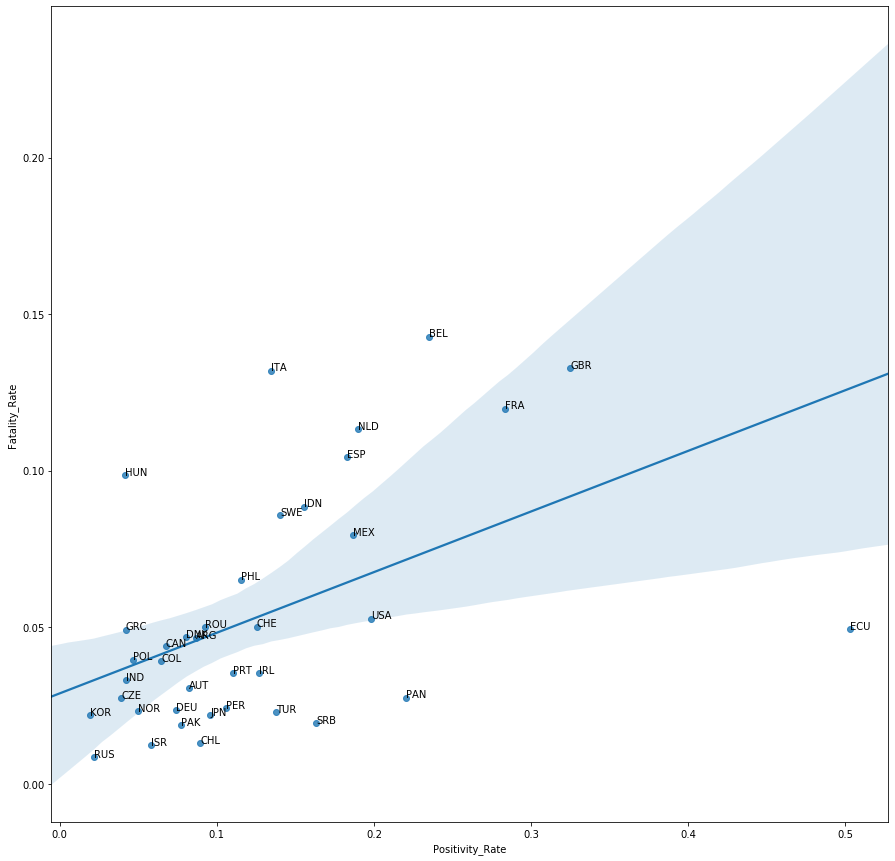

In [252]:
## rename label
DFZ.rename({'positivity_rate':"Positivity_Rate","death_rate":"Fatality_Rate"},axis=1,inplace=True)

fig,axs=plt.subplots(figsize=(15,15))
sns.regplot(x='Positivity_Rate',y='Fatality_Rate',data=DFZ,ax=axs)

for label,posy,posx in zip(DFZ['ISO3'],DFZ["Fatality_Rate"],DFZ['Positivity_Rate']):
    axs.text(posx,posy,label)

we decide to drop ecuador

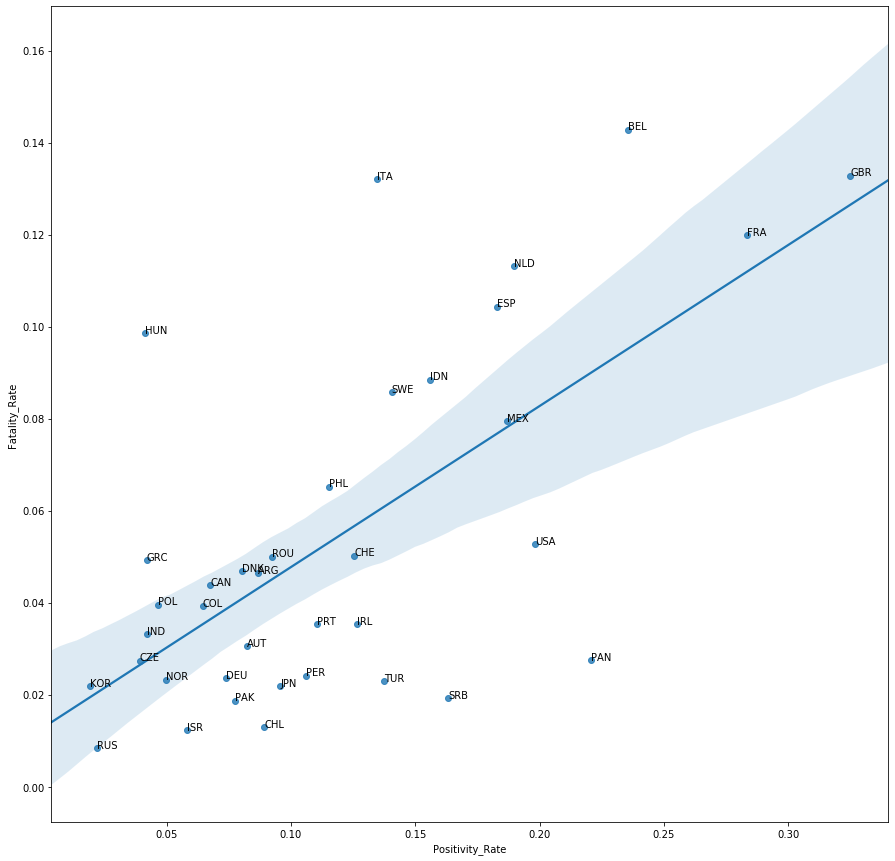

In [253]:
DFZ=DFZ.loc[DFZ['ISO3']!="ECU",:].copy()

fig,axs=plt.subplots(figsize=(15,15))
sns.regplot(x='Positivity_Rate',y='Fatality_Rate',data=DFZ,ax=axs)

for label,posy,posx in zip(DFZ['ISO3'],DFZ["Fatality_Rate"],DFZ['Positivity_Rate']):
    axs.text(posx,posy,label)

In [255]:
results=smf.ols('Fatality_Rate  ~ + Positivity_Rate ',data=DFZ).fit(cov_type='HC2')

In [256]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Fatality_Rate   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     29.26
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           4.65e-06
Time:                        18:41:13   Log-Likelihood:                 79.357
No. Observations:                  37   AIC:                            -154.7
Df Residuals:                      35   BIC:                            -151.5
Df Model:                           1                                         
Covariance Type:                  HC2                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0127      0.008      1.689      0.091      -0.002       0.028
Positivity_Rate     0.3502      0.065      5.409      0.000       0.223       0.477
==============================================================================
Omnibus:                        3.354   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                2.079
Skew:                           0.467   Prob(JB):                        0.354
Kurtosis:                       3.691   Cond. No.                         14.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

residuals differences

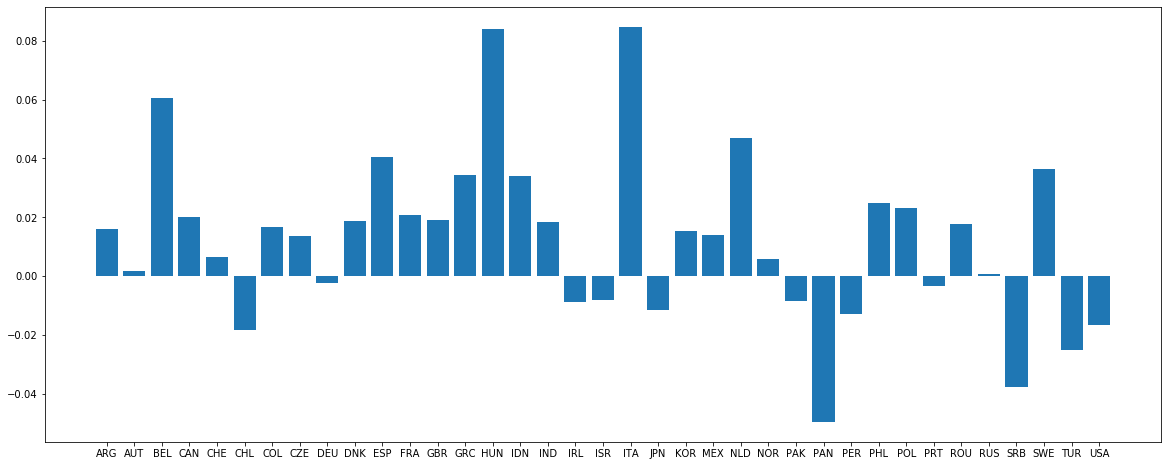

In [257]:
fig,axs=plt.subplots(figsize=(20,8))
DFZ['actual_death_rate']=results.resid+results.params[0]
plt.bar(height=DFZ['actual_death_rate'],x=DFZ['ISO3']);
#plt.bar(height=DFZ['share_65_plus'],x=DFZ['ISO3'])

### applying the same framework for italy

In [4]:
### carica file...
url="https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
DB_reg=pd.read_csv(url)
url_2="https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv"
DB_prov=pd.read_csv(url_2)
DB_reg.set_index(pd.to_datetime(DB_reg['data'].apply(str)),inplace=True)

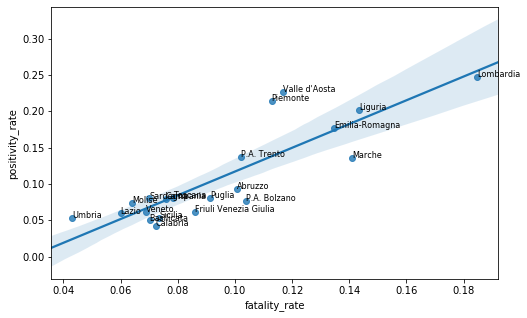

In [8]:
fig,axs=plt.subplots(figsize=(8,5))
DD=DB_reg.groupby('denominazione_regione',as_index=False)['totale_casi','tamponi','deceduti','ricoverati_con_sintomi','totale_ospedalizzati'].last()
DD['fatality_rate']=DD['deceduti']/DD['totale_casi']
DD['positivity_rate']=DD['totale_casi']/DD['tamponi']
DD.sort_values('fatality_rate',ascending=False).round(3)
sns.regplot(DD['fatality_rate'],DD['positivity_rate']);

for x,y,label in zip(DD['fatality_rate'],DD['positivity_rate'],DD['denominazione_regione']):
    axs.text(x,y,label,fontsize=8)

In [11]:
results=smf.ols('fatality_rate  ~ + positivity_rate ',data=DD).fit(cov_type='HC2')

In [12]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fatality_rate   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     26.81
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           5.35e-05
Time:                        18:52:00   Log-Likelihood:                 55.440
No. Observations:                  21   AIC:                            -106.9
Df Residuals:                      19   BIC:                            -104.8
Df Model:                           1                                         
Covariance Type:                  HC2                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0460      0.008      5.725      0.000       0.030       0.062
positivity_rate     0.4493      0.087      5.178      0.000       0.279       0.619
==============================================================================
Omnibus:                        0.044   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.978   Jarque-Bera (JB):                0.262
Skew:                          -0.033   Prob(JB):                        0.877
Kurtosis:                       2.457   Cond. No.                         15.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""